In [6]:
from astropy.io import fits, ascii
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt
import os, time
import matplotlib.patches as patches
from matplotlib.patches import Rectangle as rect
from photutils import DAOStarFinder
from astropy.table import QTable
from astropy.stats import mad_std
from photutils import aperture_photometry, CircularAperture, CircularAnnulus
from a345_utilities import print_header         # to use this in your own scripts copy the file a345_utilities.py to your work directory
import astropy.units as unit
from astropy.wcs.utils import pixel_to_skycoord
from photutils import CircularAperture, CircularAnnulus, SkyCircularAperture, aperture_photometry
from photutils import IRAFStarFinder
from astropy.stats import sigma_clipped_stats
from textwrap import wrap

number of stars found 914


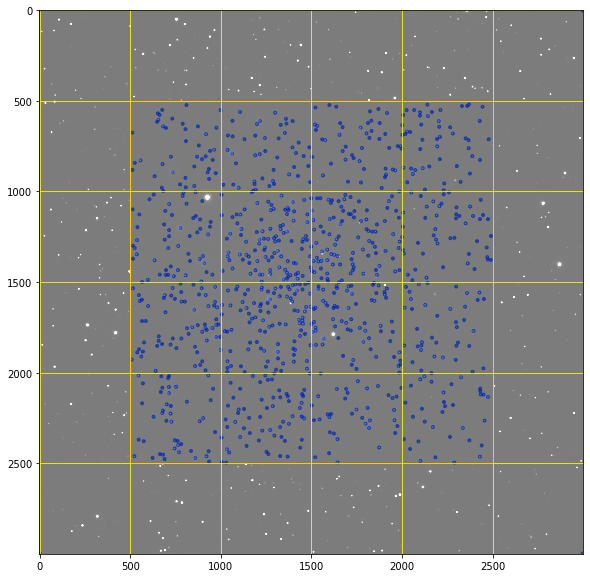

In [2]:
path = f'/data/observatory/student_data/Alasdairs File/'

image_filename = f'Output_Files/Cluster Photometry/M67/SolCal_M67_LIGHT_G_300_-5C_20210314_213405_806_W_0003.fits'
#image_filename = f'Output_Files/Cluster Photometry/M67/SolCal_M67_LIGHT_G_120_-5C_20210203_020556_449_E_0002.fits'
dat_filename =  f'M67/Calibrated_1800x1200/R/data_Corrected_1800x1200_M67_LIGHT_R_120_-5C_20210203_025553_651_E_0002.dat'

#import fit
with fits.open(path + image_filename) as hdu:
    header = hdu[0].header
    data = hdu[0].data

wcs = WCS(header)

data_std = mad_std(data)
d_mean = np.mean(data);     # mean intensity
d_std  = np.std(data);     

bkg_sigma = mad_std(data)        # get a measure of the image noise level
PhtmtryStars = IRAFStarFinder(fwhm=4, 
                                threshold=5*bkg_sigma, 
                                #minsep_fwhm=2, 
                                brightest=2000)     # set the detection threshold for a source based on the image noise


mask = data.copy()
image_centre=[int(mask.shape[1]/2),int(mask.shape[0]/2)]
w=2000; h=2000; #Sub image size
p=[(image_centre[0] - int(w/2)),(image_centre[1] - int(h/2))]
mask[:,:]= np.mean(data)

rect = patches.Rectangle(p,w,h, linewidth=1, edgecolor='r', facecolor='none')

for u in range(p[0],p[0]+w):
    for v in range(p[1],p[1]+h):
        mask[u,v] = data[u,v]

sources = PhtmtryStars(mask)  
for col in sources.colnames:  
    sources[col].info.format = '%.6g'  # for consistent table output
sources.sort('flux')
sources.reverse()
pix_stars = np.transpose((sources['xcentroid'], sources['ycentroid']))
x_stars,y_stars = pix_stars[:,0],pix_stars[:,1]
ra, dec = wcs.wcs_pix2world(x_stars, y_stars, 1)
stars = np.transpose((ra,dec))

print('number of stars found %s' %(len(ra)))
        
# plot the solved image using the wcs projection
fig, ax = plt.subplots(figsize=(16,10))
#ax = plt.subplot(projection=wcs)
mean_intensity = np.median(data)
rng=1.025
#cmin = mean_intensity/rng; cmax = mean_intensity*rng;
ax.imshow(data, vmin= d_mean-d_std, vmax= d_mean +d_std, cmap = "gray")
ax.add_patch(rect)
ax.grid(color='yellow', ls='solid')
        
fwhm = np.mean(sources['fwhm'])
pix_radius = 4*fwhm/2 # 4 times the average star raduis to collect all the possible photons
In_ann = pix_radius*1.2; Out_ann = (In_ann+1)*1.3 # annulus measurements from 1.2*aperture to 1.3*aperture
apertures_labels = CircularAperture(pix_stars, r=pix_radius)
apertures_labels.plot(color='green', lw=2, alpha=0.5)
ann_labels = CircularAnnulus(pix_stars, r_in=In_ann, r_out=Out_ann)
ann_labels.plot(color='blue', lw=1, alpha=0.5)

<Figure size 720x576 with 0 Axes>

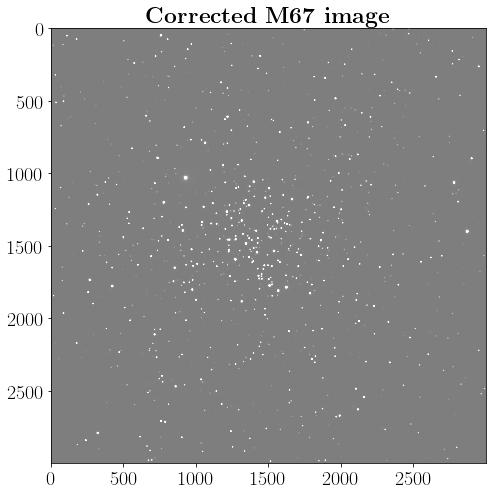

In [17]:
# plot the solved image using the wcs projection
fig2 = plt.figure(figsize=[10,8])
plt.figure(figsize=[10,8])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=23)     # fontsize of the axes title
plt.rc('axes', labelsize=23)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=23)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

mean_intensity = np.median(data)
rng=1.025
cmin = mean_intensity/rng; cmax = mean_intensity*rng;
plt.imshow(data, vmin= cmin, vmax= cmax, cmap="gray")
plt.title(r'\textbf{Corrected M67 image}')
#plt.title(r'\textbf{Apertures around a M67 source}')
#plt.xlim([1030, 1050])
#plt.ylim([1535, 1558])
#ax1.add_patch(rect)
plt.savefig('../raw_M67.png')
#fwhm = np.mean(sources['fwhm'])
#pix_radius = 4*fwhm/2 # 4 times the average star raduis to collect all the possible photons
#In_ann = pix_radius*1.2; Out_ann = (In_ann+1)*1.3 # annulus measurements from 1.2*aperture to 1.3*aperture
#apertures_labels = CircularAperture(pix_stars, r=pix_radius)
#apertures_labels.plot(color='blue', lw=2, alpha=0.5)
#ann_labels = CircularAnnulus(pix_stars, r_in=In_ann, r_out=Out_ann)
#ann_labels.plot(color='red', lw=1, alpha=0.5)
#plt.savefig("../annulus_M67.png")

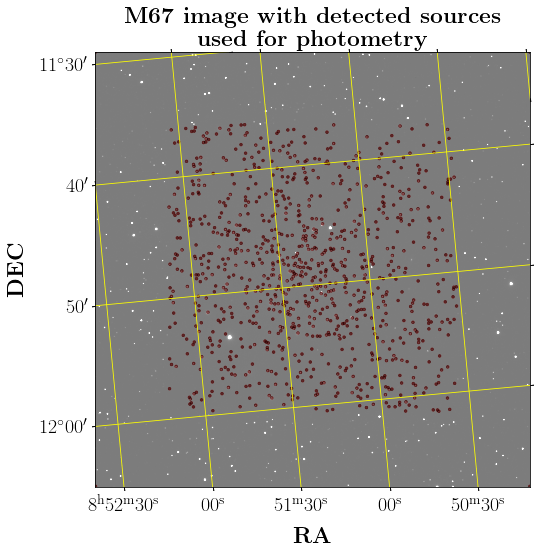

In [15]:
# plot the solved image using the wcs projection
fig2 = plt.figure(figsize=[10,8])
ax = plt.subplot(projection=wcs)

#ax = plt.subplot(projection=wcs)
mean_intensity = np.median(data)
rng=1.025
#cmin = mean_intensity/rng; cmax = mean_intensity*rng;
plt.imshow(data, vmin= d_mean-d_std, vmax= d_mean +d_std, cmap = "gray")
#ax1.add_patch(rect)
plt.grid(color='yellow', ls='solid')
ax.coords['ra'].set_ticklabel_position('b')
ax.coords['dec'].set_ticklabel_position('l')
ax.coords['ra'].set_axislabel(r'\textbf{RA}')
ax.coords['dec'].set_axislabel(r'\textbf{DEC}')
#plt.title("\n".join(wrap(r'\textbf{M67 image with detected sources used for photometry}', 35)))
plt.title(r' \textbf{M67 image with detected sources}'
        
          "\n"
          r'\textbf{used for photometry}')
fwhm = np.mean(sources['fwhm'])
pix_radius = 4*fwhm/2 # 4 times the average star raduis to collect all the possible photons
In_ann = pix_radius*1.2; Out_ann = (In_ann+1)*1.3 # annulus measurements from 1.2*aperture to 1.3*aperture
apertures_labels = CircularAperture(pix_stars, r=pix_radius)
apertures_labels.plot(color='red', lw=2, alpha=0.5)
ann_labels = CircularAnnulus(pix_stars, r_in=In_ann, r_out=Out_ann)
ann_labels.plot(color='k', lw=1, alpha=0.5)
plt.savefig("../calibrated_M67.png")

In [5]:
flux = sources["flux"]
peak = sources["peak"]
    
#Convert pixels to RA and dec
i, sky = zip(*enumerate(wcs.pixel_to_world(sources["xcentroid"],sources["ycentroid"])))
ra = [s.ra for s in sky]
dec = [s.dec for s in sky]

#Assign converted coordinates
#ra = [c.ra.to_string(unit = unit.hour, sep=("h ", "m ", "s ")) for c in coord]
#dec = [c.dec.to_string(unit = unit.degree, sep=("d ", "m ", "s ")) for c in coord]

#create table
    
t = QTable([i, ra , dec , flux, peak], names=("Index", 'RA','DEC', 'flux', "peak"), masked=True)
    
for row in t:
    if row["peak"] > 60000:
        row["flux"] = "NaN"
    pass
t.sort("flux")
#ascii.write(t, f'/data/observatory/student_data/natalia_bajnokova/M67/Calibrated_3000x3000/data_cluster_stars.dat')

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


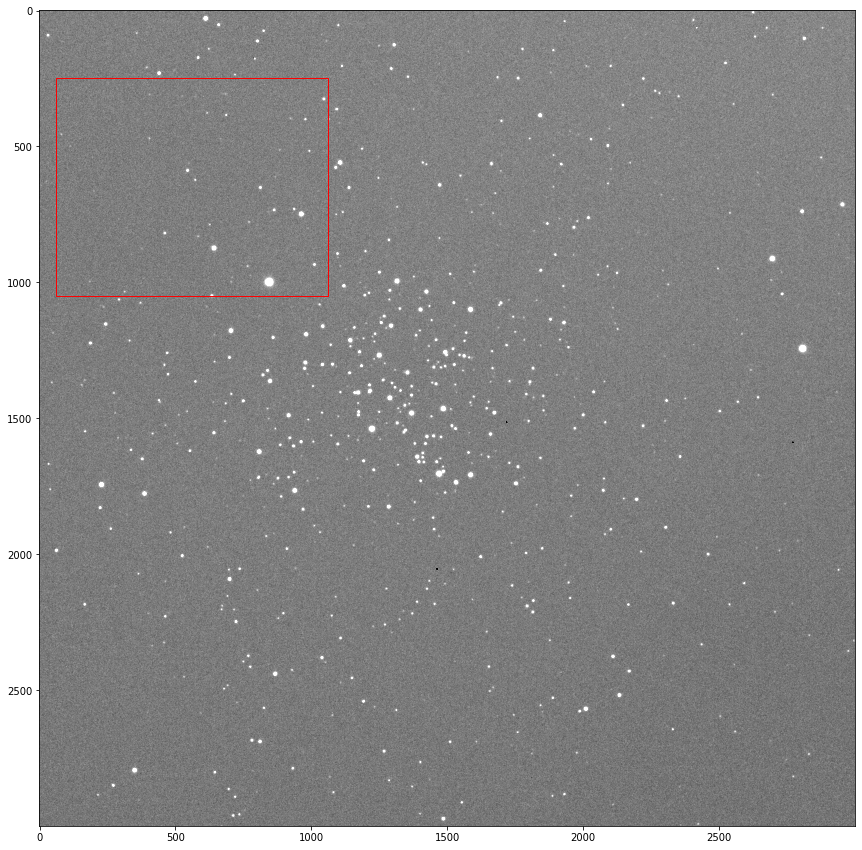

In [7]:
"""
rect = patches.Rectangle((60, 250), 1000, 800, linewidth=1, edgecolor='r', facecolor='none')
d_mean = np.mean(data)
rng=2
cmin = d_mean/rng; cmax = d_mean*rng

d_mean = np.mean(data);     # mean intensity
d_std  = np.std(data);      # standard deviation of intensity
d_min = np.min(data);
d_max = np.max(data);
d_med = np.median(data);
vmin = d_mean - d_std/2     # brightness at colour scale minimum
vmax = d_mean + d_std       # brightness at colour scale maximum
d_lower=d_min
d_upper=(d_max*d_med)**0.5

fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(data, vmin= d_mean-d_std, vmax= d_mean +d_std, cmap = "gray")
ax.add_patch(rect)
ax.plot()

mask = np.zeros(data.shape, dtype=bool)
mask[0:50,:] = True
mask[1050:, :] = True
mask[:, :250] = True
mask[:, 1050:] = True

#np.set_printoptions(threshold=np.inf)
print (mask)
iraf = IRAFStarFinder(fwhm=4, threshold=5*data_std, brightest=1000)
   

stars = iraf.find_stars(data, mask = mask)

flux = stars["flux"]
peak = stars["peak"]
    
#Convert pixels to RA and dec
i, sky = zip(*enumerate(wcs.pixel_to_world(stars["xcentroid"],stars["ycentroid"])))
ra = [s.ra for s in sky]
dec = [s.dec for s in sky]

#Assign converted coordinates
#ra = [c.ra.to_string(unit = unit.hour, sep=("h ", "m ", "s ")) for c in coord]
#dec = [c.dec.to_string(unit = unit.degree, sep=("d ", "m ", "s ")) for c in coord]

#create table
    
t = QTable([i, ra , dec , flux, peak], names=("Index", 'RA','DEC', 'flux', "peak"), masked=True)
    
for row in t:
    if row["peak"] > 60000:
        row["flux"] = "NaN"
    pass
t.sort("flux")
ascii.write(t, f'/data/observatory/student_data/natalia_bajnokova/M67/Calibrated_1800x1200/data_cluster_stars.dat')
"""
